This notebook explores, transforms, and visualizes data from the bestselling novel NORMAL PEOPLE by Sally Rooney.

Table of Contents:
1. Load Novel
2. Clean Dataset
3. Perform Sentiment Analysis
4. Visualize Character-Adjacent Words
5. Plot Metrics Across Chapters

1. Load Novel

In [1]:
import io
import requests
from PyPDF2 import PdfReader

# Set url as the url of the web-pdf with the text of the novel
url = 'http://marul.ffst.hr/~bwillems/fymob/npsr.pdf'

r = requests.get(url)
f = io.BytesIO(r.content)

# Set ppl_txt as the contents of the PDF in one string
reader = PdfReader(f)
ppl_txt = ''
for page in reader.pages:
    ppl_txt += page.extract_text() + '\n'

# Encode and then decode the text
ppl_txt = ppl_txt.encode("windows-1252").decode("unicode_escape")

# Replace some special characters inherent to the PDF format
ppl_txt = ppl_txt.replace('\t',' ').replace('\x92',"'").replace('\n',' ')

In [2]:
# Tokenize ppl_txt into a list of words (wt_all) and sentences (st_all)
import nltk

from nltk.tokenize import word_tokenize
wt_all = word_tokenize(ppl_txt)

from nltk.tokenize import sent_tokenize
st_all = sent_tokenize(ppl_txt)

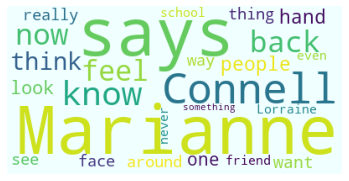

In [3]:
# Create wordcloud
import matplotlib.pyplot as mpLib

# Create stopword list:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

# Add more words to ignore 
stopwords.update(["S","re", "say", "said", "don't", "didn't"])

# Redo stop words. Limit number of words
wordcloud = WordCloud(stopwords=stopwords, max_words=25, \
                      background_color="azure").generate(ppl_txt)

# Display wordcloud
mpLib.imshow(wordcloud)
mpLib.axis("off")
mpLib.show()

2. Clean dataset

In [4]:
# Find the beginning and end of the novels to exclude
ack = [st_all.index(x) for x in st_all if 'Acknowledgements' in x]
start = ack[0]
end = ack[1]
st1 = st_all[start:end]

# Narrow focus of dataset to words in the text after the word "Copyright"
keyword = 'Copyright '
x = st1[0].find(keyword) + len(keyword)
new_firstline = st1[0][x:]
st1[0] = new_firstline

In [5]:
import re

chap_title =['January 2011']
reg = '.+\( [A-Za-z]+ +[0-9]{4} \)'
# Identify text matching the above pattern and add to list of Chapter Titles
for sent in st1:
    m = re.search(reg, sent)
    if m:
        chap_title.append(m.group())
chap_title

['January 2011',
 'Three Weeks Later ( FEBRUARY 2011 )',
 'One Month Later ( MARCH 2011 )',
 'Six Weeks Later ( APRIL 2011 )',
 'Two Days Later ( APRIL 2011 )',
 'Four Months Later ( AUGUST 2011 )',
 'Three Months Later ( NOVEMBER 2011 )',
 'Three Months Later ( FEBRUARY 2012 )',
 'Two Months Later ( APRIL 2012 )',
 'Three Months Later ( JULY 2012 )',
 'Six Weeks Later ( SEPTEMBER 2012 )',
 'Four Months Later ( JANUARY 2013 )',
 'Six Months Later ( JULY 2013 )',
 'Five Months Later ( DECEMBER 2013 )',
 'Three Months Later ( MARCH 2014 )',
 'Four Months Later ( JULY 2014 )',
 'Five Minutes Later ( JULY 2014 )',
 'Seven Months Later ( FEBRUARY 2015 )']

In [6]:
# If tokenization split a line ending with "says" or "said", re-combine the two lines and create a new list 
st2 = []
for i, sent in enumerate(st1):
    if ('says' in sent or 'said' in sent) and len(sent.split()) == 2:
        st2.append(st1[i-1] + ' ' + st1[i])
    elif (i < len(st1)-1) and ('says' in st1[i+1] or 'said' in st1[i+1]):
        pass
    else:
        st2.append(st1[i])

# Remove asterisks from text (product of extracting from PDF)
st2 = [x.replace('* ','') for x in st2]

In [7]:
from tkinter import S
from textblob import TextBlob
import pandas as pd

# Create list to categorize word polarity into Positive, Neutral or Negative
labels = ["Neutral", "Positive", "Negative"]

# Initialize count array
values =[0,0,0]

# Identify chapter titles within the lines.
# Categorize each line as "chapter title" or "sentence" in the "typ" list
sent = []
typ = []
todel = []
for s in st2:
    for t in chap_title:
        if t in s:
            p1 = t
            p2 = s.replace(t + ' ', '')
            sent.append(p1)
            typ.append('chapter title')
            sent.append(p2)
            typ.append('sentence')
            todel.append(s)
        else:
            continue
    sent.append(s)
    typ.append('sentence')

In [8]:
# Create new Dataframe with sent and typ columns
df = pd.DataFrame(sent, columns= {'sent'})
df['typ'] = typ

# Identify duplicate chapter title sentences and add deletion marker
todel1 = []
for i,r in df.iterrows():
    if r['sent'] in todel and r['typ'] == 'sentence':
        todel1.append('delete')
    else:
        todel1.append('keep')
df['to_del'] = todel1

# Include only non-duplicate records and reset index
df = df[df['to_del']=='keep']
df = df[['sent', 'typ']]
df = df.reset_index(drop=True)

# Display count of sentences in new dataframe
len(df)

5380

3. Perform Sentiment Analysis

Final summarized counts : [2840, 1413, 1127]


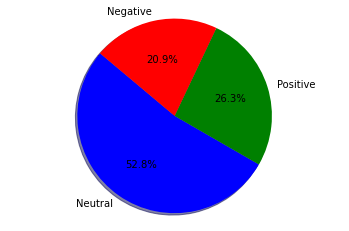

In [9]:
# Assign a polarity to each sentence
st = df['sent']
word_pol = []
num_pol = []
num_sbj = []

for sent in st:
    sentiment = TextBlob(sent)
    pol = sentiment.polarity
    sbj = sentiment.subjectivity
    
    # Convert polarity to string and integer
    if sentiment.polarity > 0:
        npol = 1
        wpol = 'positive'
    elif sentiment.polarity < 0:
        npol = 2
        wpol = 'negative'
    else:
        npol = 0
        wpol = 'neutral'

    values[npol] = values[npol] + 1
    word_pol.append(wpol)
    num_pol.append(pol)
    num_sbj.append(round(sbj,2))
    
# Print neutral, positive, and negative sentence counts
print("Final summarized counts :", values)

# Add polarity assignments to dataframe
df['polarity'] = num_pol
df['polarity_desc'] = word_pol
df['subjectivity'] = sbj

# Add last character column to dataframe
last_char = []
for i,r in df.iterrows():
    last_char.append(r['sent'][-1])
df['last_char'] = last_char

# Create pie chart with proportions of sentences by polarity
import matplotlib.pyplot as plt
colors=["Blue","Green","Red"]
plt.pie(values, labels=labels, colors=colors, \
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

In [10]:
# Create string of full novel with only sentences
nov = ' '.join(df[df['typ']=='sentence']['sent'])

# Create list of words from sentences only
from collections import Counter
import string
# Split novel by whitepace character
nov_spl = nov.split(' ')
# Loop through words and add to new list. If word ends in apostrophe + s, cut out these two characters.
# Do this to aid in counting occurrences of novel character names in the text
wrd0 = [word.translate(str.maketrans('', '', string.punctuation)) for word in nov_spl]
wrd = []
for w in wrd0:
    if w[-2:] == "'s":
        wrd.append(w[:-2])
    else:
        wrd.append(w)

# Create list of sentences only
sent = df[df['typ']=='sentence']['sent']

# Add column for count of words
cnt = []
for i,r in df.iterrows():
    wrds = r['sent'].split(' ')
    c = len(wrds)
    cnt.append(c)
df['word_count'] = cnt

# Print basic metrics
print(
    'total df row count:', len(df), '| '
    'character count:', len(nov), '| '
    'word count:', len(wrd), '| '
    'sentence count:', len(sent))

total df row count: 5380 | character count: 335595 | word count: 61531 | sentence count: 5362


In [11]:
# Create a lemmatized list of words and compare to non-lemmatized
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

wrd_l = []
for w in nov_spl:
    if w[-2:] == "'s":
        wrd_l.append(w[:-2])
    else:
        wrd_l.append(w)

# Create a new dataframe with the original word and the lemmatized word
tup = zip(wrd, wrd_l)
lem_df = pd.DataFrame(tup,columns=['orig', 'lem'])
lem_df[lem_df['orig']!=lem_df['lem']]

# Create a new version of each column with no punctuation included
orig1 = [word.translate(str.maketrans('', '', string.punctuation)) for word in lem_df['orig']]
lem1 = [word.translate(str.maketrans('', '', string.punctuation)) for word in lem_df['lem']]
lem_df['orig_clean'] = orig1
lem_df['lem_clean'] = lem1

# Display cases where the original differs from the lemmatized word
lem_df[['orig_clean','lem_clean']][lem_df['orig_clean']!=lem_df['lem_clean']].head()

,orig_clean,lem_clean
146,Shes,She
279,Its,It
337,Shes,She
351,its,it
409,Thats,That


4. Visualize Character-Adjacent Words

In [12]:
# Create a dataframe with each word in the text and its Part of Speech, as identified by NLTK
pos_tup = nltk.pos_tag(wrd)
pdf1 = pd.DataFrame(pos_tup,columns=['word', 'part']).value_counts().reset_index()
pdf1.rename(columns={0:'ct'}, inplace=True)

# Loop through a unique list of the words and identify Part of Speech with NLTK
pos_mc = []
occ_ct = []
word_uni = set(pdf1['word'])
for word in word_uni:
    # Take the Part of Speech in the 0th position (the POS that NLTK identified for that word most often)
    mc = list(pdf1[pdf1['word']==word]['part'])[0]
    ct = pdf1[pdf1['word']==word]['ct'].sum()
    pos_mc.append(mc)
    occ_ct.append(ct)

# Create a new dataframe with the unique list of lemmatized words, their most common part of speech,
# and the number of occurrences of that word in the text
tup = list(zip(word_uni, pos_mc, occ_ct))
wdf = pd.DataFrame(tup,columns=['word', 'pos','ct'])
wdf[1:].head()

,word,pos,ct
1,unendurably,RB,1
2,films,NNS,3
3,wait,VB,4
4,pasta,NN,2
5,baking,VBG,1


In [13]:
wrd_adj = []
wrd_person = []
wrd_pos = []

# Loop through each sentence and identify the words that are adjacent to mentions of Marianne or Connell
for s in sent:
    ss = s.split()
    for i, e in enumerate(ss):       
        if e in ('Connell','Marianne'):
            # For cases where the character name is NOT the first in the sentence, collect data
            if i != 0:
                w_prior = ss[i-1]
                w_pos = wdf[wdf['word']==w_prior]['pos'].values
                # Collect the word prior to the name
                wrd_adj.append(w_prior)
                # Collect the name of the character
                wrd_person.append(e)
                # If the word exists in the Part of Speech dataframe, collect the Part of Speech
                if len(w_pos)>0:
                    wrd_pos.append(w_pos[0])
                else:
                    wrd_pos.append('None found')
            # For cases where the character name is NOT the LAST in the sentence, collect data
            if i != len(ss)-1:
                w_after = ss[i+1]
                w_pos = wdf[wdf['word']==w_after]['pos'].values
                # Collect the word after the name
                wrd_adj.append(w_after)
                # Collect the name of the character
                wrd_person.append(e)
                # Collect the part of speech
                if len(w_pos)>0:
                    wrd_pos.append(w_pos[0])
                else:
                    wrd_pos.append('None found')

# Create a new dataframe with the adjacent word, relevant character, and part of speech
tup = list(zip(wrd_adj, wrd_person, wrd_pos))
adf = pd.DataFrame(tup,columns=['adjacent_word', 'person','pos'])
adf.head()

,adjacent_word,person,pos
0,answers,Marianne,VBZ
1,when,Connell,WRB
2,rings,Connell,VBZ
3,"Right,",Connell,None found
4,says.,Connell,None found


In [14]:
from wordcloud import WordCloud, STOPWORDS

# Define a function to create wordcloud with arguments for Character, Part of Speech, and Stopwords
def CreateCloud(character, pos, stop: list):
    ser = adf[(adf['person']==character)&(adf['pos'].isin(pos))]['adjacent_word']
    lst = list(ser)
    strng = ' '.join(lst)
    wordcloud = WordCloud(stopwords=stop, max_words=25, \
                        background_color="azure").generate(strng)
    mpLib.imshow(wordcloud)
    mpLib.axis("off")
    mpLib.show()

# Create lists with the relevant Part of Speech NLTK codes
adjective = ['JJ','JJR','JJS']
verb = ['VB','VBG','VBD','VBN','VBP','VBZ']
adverb = ['RB','RBR','RBS','RP']


Marianne Adjectives:


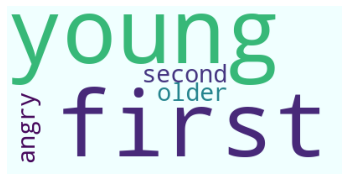

Connell Adjectives:


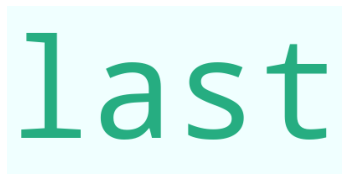

Marianne Verbs:


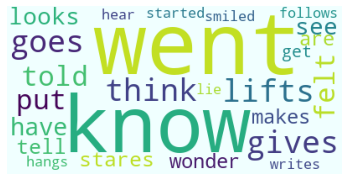

Connell Verbs:


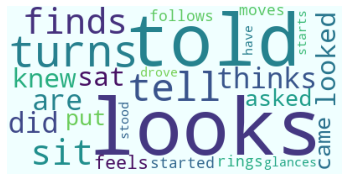

Marianne Adverbs:


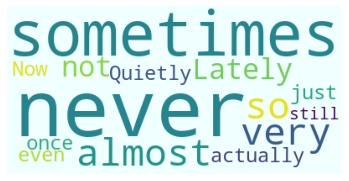

Connell Adverbs:


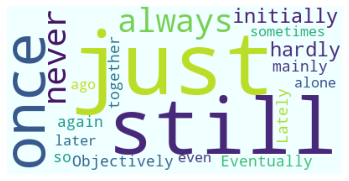

In [15]:
# Generate Wordclouds using the new function

print('Marianne Adjectives:')
CreateCloud('Marianne',adjective,stop=['concludes', 'pregnant'])
print('Connell Adjectives:')
CreateCloud('Connell',adjective,stop=['was'])

print('Marianne Verbs:')
CreateCloud('Marianne',verb,stop=['had', 'has', 'is','said','was','says'])
print('Connell Verbs:')
CreateCloud('Connell',verb,stop=['had', 'has', 'is','said','was','says'])

print('Marianne Adverbs:')
CreateCloud('Marianne',adverb,stop=['up','down','then', 'nodded','apart'])
print('Connell Adverbs:')
CreateCloud('Connell',adverb,stop=['up','down','then', 'nodded','apart'])

5. Plot Metrics Across Chapters

In [16]:
# Create list of chapters
ch = (df[df['typ']=='chapter title']['sent']).reset_index(drop=True)
print('count of chapters: ',len(ch))

# Assign each sentence into its respective chapter
chap = []
n = 0
for i in range(len(df)):
    if i == 0:
        chap.append(ch[n])
    elif df['typ'].iloc[i] == 'chapter title':
        chap.append(ch[n])
        n += 1
    else:
        chap.append(ch[n])

# Add chapter assignments to main dataframe
df['chapter'] = chap
df = df[['sent', 'typ', 'polarity', 'polarity_desc', 'word_count', 'chapter']]

count of chapters:  18


In [17]:
# Add chapter number to chapter name
i = 0
chap_title1 = []

for c in chap_title:
    chap_title1.append(i+1)
    i += 1

ct = list(zip(chap_title, chap_title1))
ctdf = pd.DataFrame(ct, columns=['chap', 'num_chapter'])
df = df.merge(ctdf, how='left', left_on='chapter', right_on='chap')

# Take an average sentiment score at the sentence level for each chapter
chdf1 = df[df['typ']=='sentence'].groupby(['num_chapter']).mean()
chdf1 = chdf1.sort_values('num_chapter')

Text(0, 0.5, 'Sentiment Score')

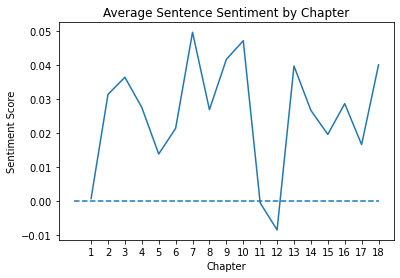

In [18]:
# Plot the change in sentiment scores across the chapters
import matplotlib.pyplot as plt

x = chdf1.index
y = chdf1['polarity']
x_ticks = chdf1.index

plt.plot(x,y)
plt.title(label='Average Sentence Sentiment by Chapter')
plt.xticks(ticks=x_ticks)
plt.hlines(y=0, xmin=0, xmax=18, linestyle='dashed')
plt.xlabel('Chapter')
plt.ylabel('Sentiment Score')



In [19]:
# Count how many times Marianne and Connell are mentioned across the chapters
m = [int('Marianne' in x) for x in df['sent']]
c = [int('Connell' in x) for x in df['sent']]

df['mention_m'] = m
df['mention_c'] = c

# Create new dataframe to capture these counts
mdf = df[(df['typ']=='sentence')].groupby(['num_chapter']).sum()
mdf = mdf.sort_values('num_chapter')


In [20]:
import numpy as np

# Create a new dataframe with each word
word1 = [word for line in sent for word in line.split()]
word2 = np.cumsum(mdf['word_count'])
wdf = pd.DataFrame(word1,columns=['word'])

range_x = []
range_y = []

# Loop through each word in the text to determine the chapter it belongs to
for i, word in enumerate(word2):
    if i == 0:
        range_x.append(0)
        range_y.append(word-1)
    elif i == 1:
        range_x.append(word2[i])
        range_y.append(word-1)
    else:
        range_x.append(word2[i])
        range_y.append(word-1)

rdf = pd.DataFrame(chap_title1,columns=['num_chapter'])
rdf['first'] = range_x
rdf['last'] = range_y

w_chap = []

# Assign each word to a chapter
for i,r in rdf.iterrows():
    for i,w in enumerate(word1):
        if i >= r['first'] and i <= r['last']:
            w_chap.append(r['num_chapter'])

# Add the chapter number to the new dataframe
wdf['num_chapter'] = w_chap

# Create a separate copy of the dataframe for plotting word occurrence
plot_df = wdf

In [21]:
# Define a new function to plot word occurrence on a line graph

def PlotWord(wordlist: list):
    wordbool = [int(w in wordlist) for w in wdf['word']]
    plot_df['plot_word'] = wordbool
    plot_df1 = plot_df.groupby(['num_chapter']).sum()
    x = plot_df1.index
    y = plot_df1['plot_word']
    x_ticks = plot_df1.index

    plt.xticks(ticks=x_ticks)
    plt.plot(x,y)
    titl = "Use of Word '"+wordlist[0]+"'"
    plt.title(titl)
    plt.xlabel('Chapter')
    plt.ylabel('Count of Occurrences')

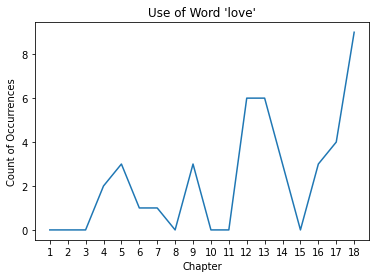

In [22]:
# Plot occurrences of the word "love" (and similar ones) across the chapters
PlotWord(['love','loved','loves'])

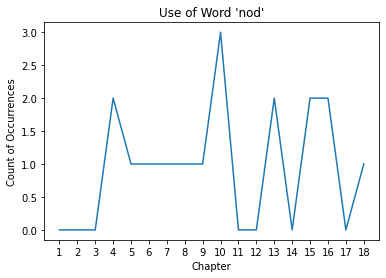

In [23]:
# Plot occurrences of the word "nod" (and similar ones) across the chapters
PlotWord(['nod','nods','nodded'])

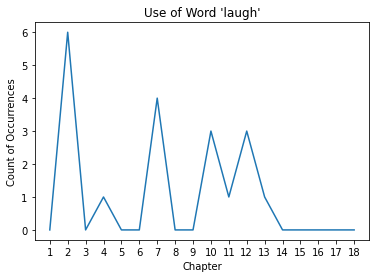

In [24]:
# Plot occurrences of the word "nod" (and similar ones) across the chapters
PlotWord(['laugh','laughs','laughed'])

In [25]:
# Import textstat to gather reading measures on the text
import textstat as ts

sdf = df[df['typ']=='sentence']

read_lvl = []
read_time = []
syl_ct = []
monosyl_ct = []
polysyl_ct = []

# For each sentence, calculate reading level, estimated reading time, 
# syllable count, count of monosyllabic words, and count of polysyllabic words
for i,r in sdf.iterrows():
    read_lvl.append(ts.text_standard(r['sent'], float_output=True))
    read_time.append(ts.reading_time(r['sent']))
    syl_ct.append(ts.syllable_count(r['sent']))
    monosyl_ct.append(ts.monosyllabcount(r['sent']))
    polysyl_ct.append(ts.polysyllabcount(r['sent']))

sdf['read_lvl'] = read_lvl
sdf['read_time'] = read_time
sdf['syl_ct'] = syl_ct
sdf['monosyl_ct'] = monosyl_ct
sdf['polysyl_ct'] = polysyl_ct


C:\Users\patrick.walsh\AppData\Local\Temp\ipykernel_25824\2043257512.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['read_lvl'] = read_lvl
C:\Users\patrick.walsh\AppData\Local\Temp\ipykernel_25824\2043257512.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['read_time'] = read_time
C:\Users\patrick.walsh\AppData\Local\Temp\ipykernel_25824\2043257512.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [26]:
# Summarize the metrics from the textstat package
sdf_n = sdf[['sent','read_lvl','read_time','syl_ct','monosyl_ct','polysyl_ct']]
sdf_n.describe()

,read_lvl,read_time,syl_ct,monosyl_ct,polysyl_ct
count,5362.000000,5362.000000,5362.000000,5362.000000,5362.000000
mean,5.107423,0.750828,14.947408,8.835882,0.712234
std,4.136816,0.570100,11.734862,6.388083,1.107787
min,-3.000000,0.040000,1.000000,0.000000,0.000000
25%,2.000000,0.350000,7.000000,4.000000,0.000000
50%,5.000000,0.600000,12.000000,7.000000,0.000000
75%,8.000000,0.980000,20.000000,12.000000,1.000000
max,33.000000,5.660000,118.000000,78.000000,10.000000


In [27]:
# Print the overall textstat metrics for the novel
print(
    'standard reading level: ',ts.text_standard(ppl_txt, float_output=True),'\n',
    'reading_time: ',ts.reading_time(ppl_txt, ms_per_char=14.69),'\n',
    'prop mono syls: ',ts.monosyllabcount(ppl_txt)/ts.syllable_count(ppl_txt),'\n',
    'prop poly syls: ',ts.polysyllabcount(ppl_txt)/ts.syllable_count(ppl_txt)
    )

standard reading level:  6.0 
 reading_time:  4812.05 
 prop mono syls:  0.5914555670653232 
 prop poly syls:  0.04704355923868119


In [28]:
# Obtain the following summary metrics on the chapter level:
# count of sentences, count of words, average word count per sentence, average sentiment, count of marianne mentions,
# count of connell mentions, proportion of positive sentences, proportion of negative sentences

sent_ct = list((sdf['num_chapter'].value_counts()).sort_index(ascending=True))
word_ct = list(sdf.groupby(['num_chapter']).sum()['word_count'])
avg_word_ct = list(sdf.groupby(['num_chapter']).mean()['word_count'])
avg_pol = list(sdf.groupby(['num_chapter']).mean()['polarity'])
m_ment = list(sdf.groupby(['num_chapter']).sum()['mention_m'])
c_ment = list(sdf.groupby(['num_chapter']).sum()['mention_c'])
pos_sent = list(sdf[sdf['polarity_desc']=='positive'].groupby(['num_chapter']).count()['sent'])
neg_sent = list(sdf[sdf['polarity_desc']=='negative'].groupby(['num_chapter']).count()['sent'])

cdf = pd.DataFrame(df.num_chapter.unique(), columns=['num_chapter'])
# Chapter name
cdf['chapter'] = list(sdf.chapter.unique())
# Sentence count in chapter
cdf['sent_ct'] = sent_ct
# Total word count in chapter
cdf['word_ct'] = word_ct
# Average word count across sentences in chapter
cdf['avg_word_ct'] = avg_word_ct
# Average polarity of chapter
cdf['avg_pol'] = avg_pol
# Count of mentions of "Marianne"
cdf['m_ment'] = m_ment
# Count of mentions of "Connell"
cdf['c_ment'] = c_ment
# Count of sentences with positive sentiment
cdf['pos_sent'] = pos_sent
# Count of sentences with negative sentiment
cdf['neg_sent'] = neg_sent
# Proportion of sentences that are positive
cdf['pos_prop'] = cdf['pos_sent']/cdf['sent_ct'] 
# Proportion of sentences that are negative
cdf['neg_prop'] = cdf['neg_sent']/cdf['sent_ct'] 
# Ratio of positive to negative sentence count
cdf['pos_neg_ratio'] = cdf['pos_sent']/cdf['neg_sent'] 
# Ratio of Marianne to Connell name occurrence
cdf['m_c_ratio'] = cdf['m_ment']/cdf['c_ment']

cdf.head()

,num_chapter,chapter,sent_ct,word_ct,avg_word_ct,avg_pol,m_ment,c_ment,pos_sent,neg_sent,pos_prop,neg_prop,pos_neg_ratio,m_c_ratio
0,1,January 2011,146,1528,10.465753,0.000707,20,10,31,28,0.212329,0.191781,1.107143,2.000000
1,2,Three Weeks Later ( FEBRUARY 2011 ),197,2460,12.487310,0.031375,15,10,49,45,0.248731,0.228426,1.088889,1.500000
2,3,One Month Later ( MARCH 2011 ),165,2089,12.660606,0.036405,27,8,47,37,0.284848,0.224242,1.270270,3.375000
3,4,Six Weeks Later ( APRIL 2011 ),341,3589,10.524927,0.027515,53,29,92,74,0.269795,0.217009,1.243243,1.827586
4,5,Two Days Later ( APRIL 2011 ),267,2856,10.696629,0.013829,14,19,53,57,0.198502,0.213483,0.929825,0.736842


Text(0, 0.5, 'Word Count')

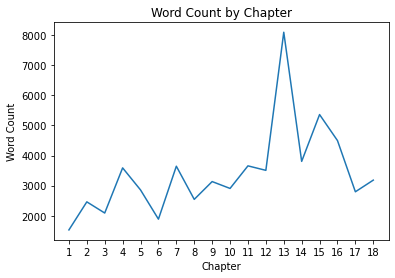

In [29]:
# Plot line graph of total word count by chapter
x = cdf.num_chapter
y1 = cdf['word_ct']

plt.xticks(ticks=cdf.num_chapter)
plt.plot(x,y1)
plt.title('Word Count by Chapter')
plt.xlabel('Chapter')
plt.ylabel('Word Count')

Text(0, 0.5, 'Count of Name Occurrences')

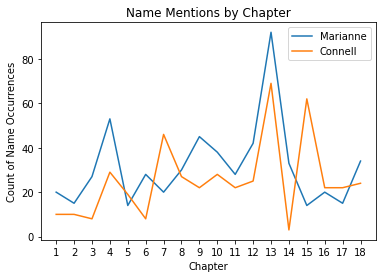

In [30]:
# Plot line graph of Connell and Marianne mention count by chapter

x = cdf.num_chapter
y1 = cdf['m_ment']
y2 = cdf['c_ment']

plt.xticks(ticks=cdf.num_chapter)
plt.plot(x,y1, label='Marianne')
plt.plot(x,y2,label='Connell')
plt.legend()
plt.title('Name Mentions by Chapter')
plt.xlabel('Chapter')
plt.ylabel('Count of Name Occurrences')

Text(0, 0.5, 'Proportion of Sentences')

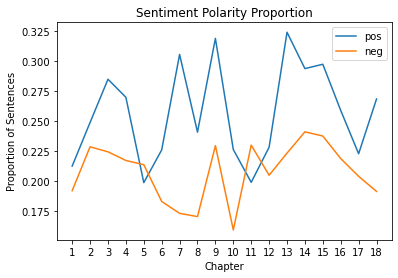

In [31]:
# Plot line graph of positive vs negative sentence count proportion

x = cdf.num_chapter
y1 = cdf['pos_prop']
y2 = cdf['neg_prop']

plt.xticks(ticks=cdf.num_chapter)
#plt.hlines(y=0, xmin=0, xmax=18, linestyle='dashed')
plt.plot(x,y1, label='pos')
plt.plot(x,y2,label='neg')
plt.legend()
plt.title('Sentiment Polarity Proportion')
plt.xlabel('Chapter')
plt.ylabel('Proportion of Sentences')